In [1]:
pip install datasets tensorflow opencv-python matplotlib pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 852.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 140.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128
DATASET_PATH = "./raw/"

images = []
labels = []

print("[INFO] Loading and processing TrashNet dataset...")


# ========================
# Load dataset
# ========================
for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path):
        continue
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            enhanced_img = enhance_image(img)
            images.append(enhanced_img)
            labels.append(label_folder)
        except Exception as e:
            print(f"[WARN] Skipped corrupt image: {img_path} - {e}")

# ========================
# Convert to NumPy
# ========================
X = np.array(images, dtype="float32")
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print(f"[INFO] Dataset ready: {len(X_train)} training samples, {len(X_test)} test samples")
print(f"[INFO] Classes: {le.classes_}")


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


[INFO] Loading and processing TrashNet dataset...
[INFO] Dataset ready: 8994 training samples, 2249 test samples
[INFO] Classes: ['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']


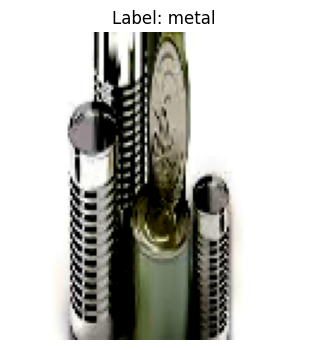

In [4]:
import matplotlib.pyplot as plt

# Show a sample image from the training set
index = 3000  # Change this to see other images
sample_image = X_train[index]

plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"Label: {le.inverse_transform([np.argmax(y_train[index])])[0]}")
plt.axis("off")
plt.show()

<Axes: >

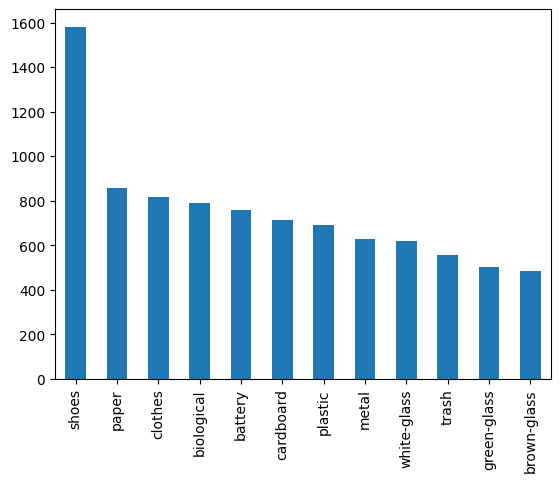

In [5]:
import pandas as pd
pd.Series(le.inverse_transform(np.argmax(y_train, axis=1))).value_counts().plot(kind='bar')

In [ ]:


train_data = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
test_data = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 128  # keep same as dataset

# Load MobileNetV2 base
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation="softmax")(x)  # dynamically set classes

model_mobilenet = Model(inputs=base_model.input, outputs=output)

# Compile
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("efficientnet_b0_best.keras", save_best_only=True, monitor="val_accuracy")
]

history_eff = model_mobilenet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.5380 - loss: 1.5973 - val_accuracy: 0.8835 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8635 - loss: 0.4327 - val_accuracy: 0.9088 - val_loss: 0.3048 - learning_rate: 0.0010
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.8809 - loss: 0.3651 - val_accuracy: 0.9164 - val_loss: 0.2848 - learning_rate: 0.0010
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9102 - loss: 0.2799 - val_accuracy: 0.9164 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9106 - loss: 0.2760 - val_accuracy: 0.9217 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9161 - loss: 0.2502 - val_accuracy: 0.9173 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9212 - l

In [9]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [10]:
import keras_tuner
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [11]:
def build_model(hp):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base

    x = GlobalAveragePooling2D()(base_model.output)

    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(dropout_rate)(x)

    # Output layer (12 classes based on your data)
    output = Dense(12, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [12]:
# Step 1: Instantiate the KerasTuner RandomSearch tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=12,
    directory='my_tuning_dir',
    project_name='trashnet_tuning'
)

print("[INFO] Starting hyperparameter search...")

# Step 2: Start the hyperparameter search
tuner.search(
    X_train,
    y_train,
    epochs=15,  # Limiting epochs for tuning speed
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

print("[INFO] Hyperparameter search complete.")

Trial 12 Complete [00h 04m 41s]
val_accuracy: 0.9159626364707947

Best val_accuracy So Far: 0.9275233149528503
Total elapsed time: 00h 56m 02s
[INFO] Hyperparameter search complete.


In [13]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] Best Hyperparameters:")
print(f"Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hp)

# Compile again (sometimes tuner already does, but just to be sure)
best_model.compile(
    optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


[INFO] Best Hyperparameters:
Dropout Rate: 0.4
Learning Rate: 0.005174671499174863


In [14]:
history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,   # More epochs since now we’re training the best model
    callbacks=callbacks,
    batch_size=32,
    verbose=1
)


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.7391 - loss: 0.9377 - val_accuracy: 0.8786 - val_loss: 0.4842 - learning_rate: 0.0052
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8813 - loss: 0.4424 - val_accuracy: 0.9053 - val_loss: 0.3974 - learning_rate: 0.0052
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8987 - loss: 0.4035 - val_accuracy: 0.8982 - val_loss: 0.4594 - learning_rate: 0.0052
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8977 - loss: 0.4198 - val_accuracy: 0.9044 - val_loss: 0.4776 - learning_rate: 0.0052
Epoch 5/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9127 - loss: 0.3502
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0010349342599511146.
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9126 - loss: 0.3504 - val_accuracy: 0.9035 - val_loss: 0.5458 - learning_rate: 0.0052
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9255 - los

In [15]:
# Save model in modern Keras format
best_model.save("mobilenet_trash.keras")

# Load model
from tensorflow.keras.models import load_model
loaded_model = load_model("mobilenet_trash.keras")

# Recompile to ensure metrics are set
loaded_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [16]:
import pickle

# Save model with pickle
with open("mobilenet_trashn.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Load model later
with open("mobilenet_trashn.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [17]:
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


[RESULT] Test Accuracy: 0.9249, Test Loss: 0.4054


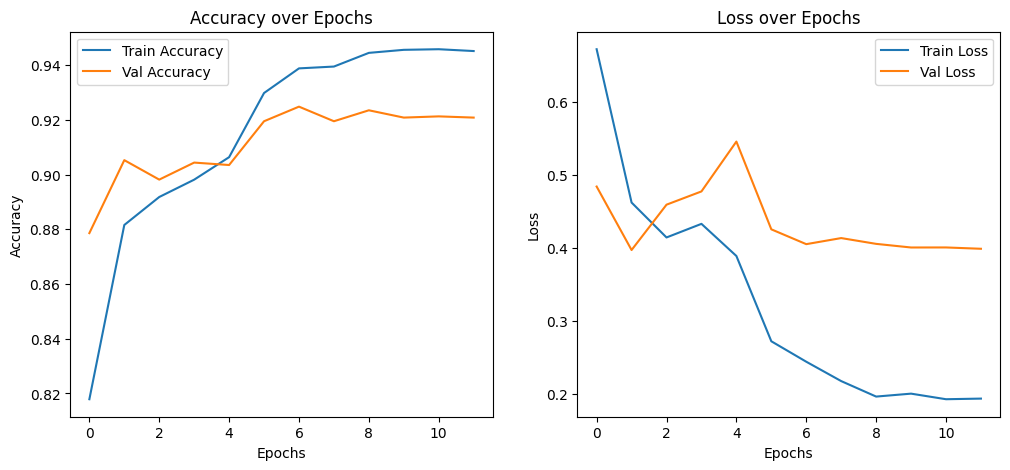

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       189
           1       0.99      0.95      0.97       197
           2       0.92      0.90      0.91       121
           3       0.93      0.95      0.94       178
           4       1.00      0.98      0.99       204
           5       0.93      0.94      0.94       126
           6       0.83      0.85      0.84       157
           7       0.92      0.86      0.89       214
           8       0.76      0.84      0.80       173
           9       0.98      0.99      0.98       396
          10       0.96      0.97      0.97       139
          11       0.85      0.79      0.82       155

    accuracy                           0.92      2249
   macro avg       0.92      0.92      0.92      2249
weighted avg       0.93      0.92      0.93      2249



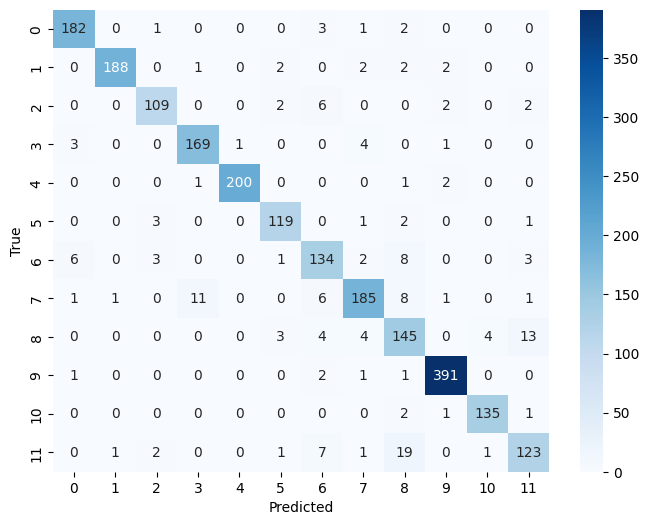

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
import pickle

# Save model architecture and weights
model_data = {
    "architecture": best_model.to_json(),   # JSON of the model
    "weights": best_model.get_weights()     # list of numpy arrays
}

# Save as pickle file
with open("mobilenet_trash.pkl", "wb") as f:
    pickle.dump(model_data, f)


In [21]:
from tensorflow.keras.models import model_from_json
import pickle

# Load pickle file
with open("mobilenet_trash.pkl", "rb") as f:
    model_data = pickle.load(f)

# Reconstruct model
loaded_model = model_from_json(model_data["architecture"])
loaded_model.set_weights(model_data["weights"])

# Compile before training or evaluating
loaded_model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [22]:
from google.colab import files

files.download("mobilenet_trash.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # same as training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image, resizes for MobileNetV2, returns both:
    - img_rgb: for displaying
    - img_input: preprocessed for model prediction
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # Resize and convert BGR -> RGB
    img_rgb = cv2.cvtColor(cv2.resize(img, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB)

    # Preprocess for model
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)

    return img_rgb, img_input


In [28]:
def show_image_and_predict(model, img_path, label_encoder):
    # Preprocess
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    preds = model.predict(img_input)
    class_idx = np.argmax(preds, axis=1)[0]
    class_label = label_encoder.inverse_transform([class_idx])[0]
    confidence = preds[0][class_idx]

    # Show image
    plt.figure(figsize=(4,4))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"{class_label} ({confidence*100:.2f}%)")
    plt.show()

    return class_label, confidence
